<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/Training_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training a deep neural network isn’t a walk in the park. Here are some of the problems you could run into:

- You may be faced with the problem of gradients growing ever smaller or larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- You might not have enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

#The Vanishing/Exploding Gradients Problems

backpropagation algorithm’s second phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem,

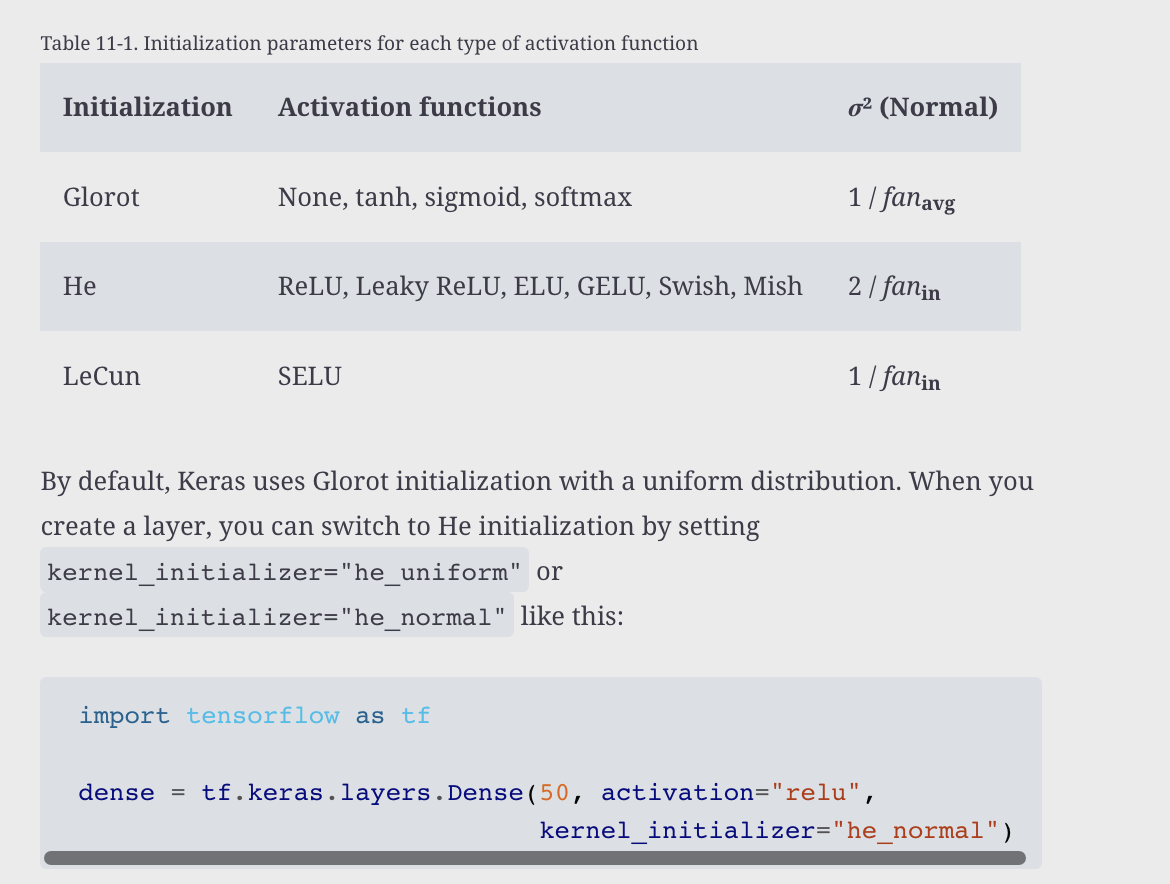

#Better Activation Functions
One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function.

ReLU activation function, mostly because it does not saturate for positive values, and also because it is very fast to compute.

In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the input of the ReLU function (i.e., the weighted sum of the neuron’s inputs plus its bias term) is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.⁠4

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU.

Keras includes the classes LeakyReLU and PReLU in the tf.keras.layers package. Just like for other ReLU variants, you should use He initialization with these.

In [2]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [3]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

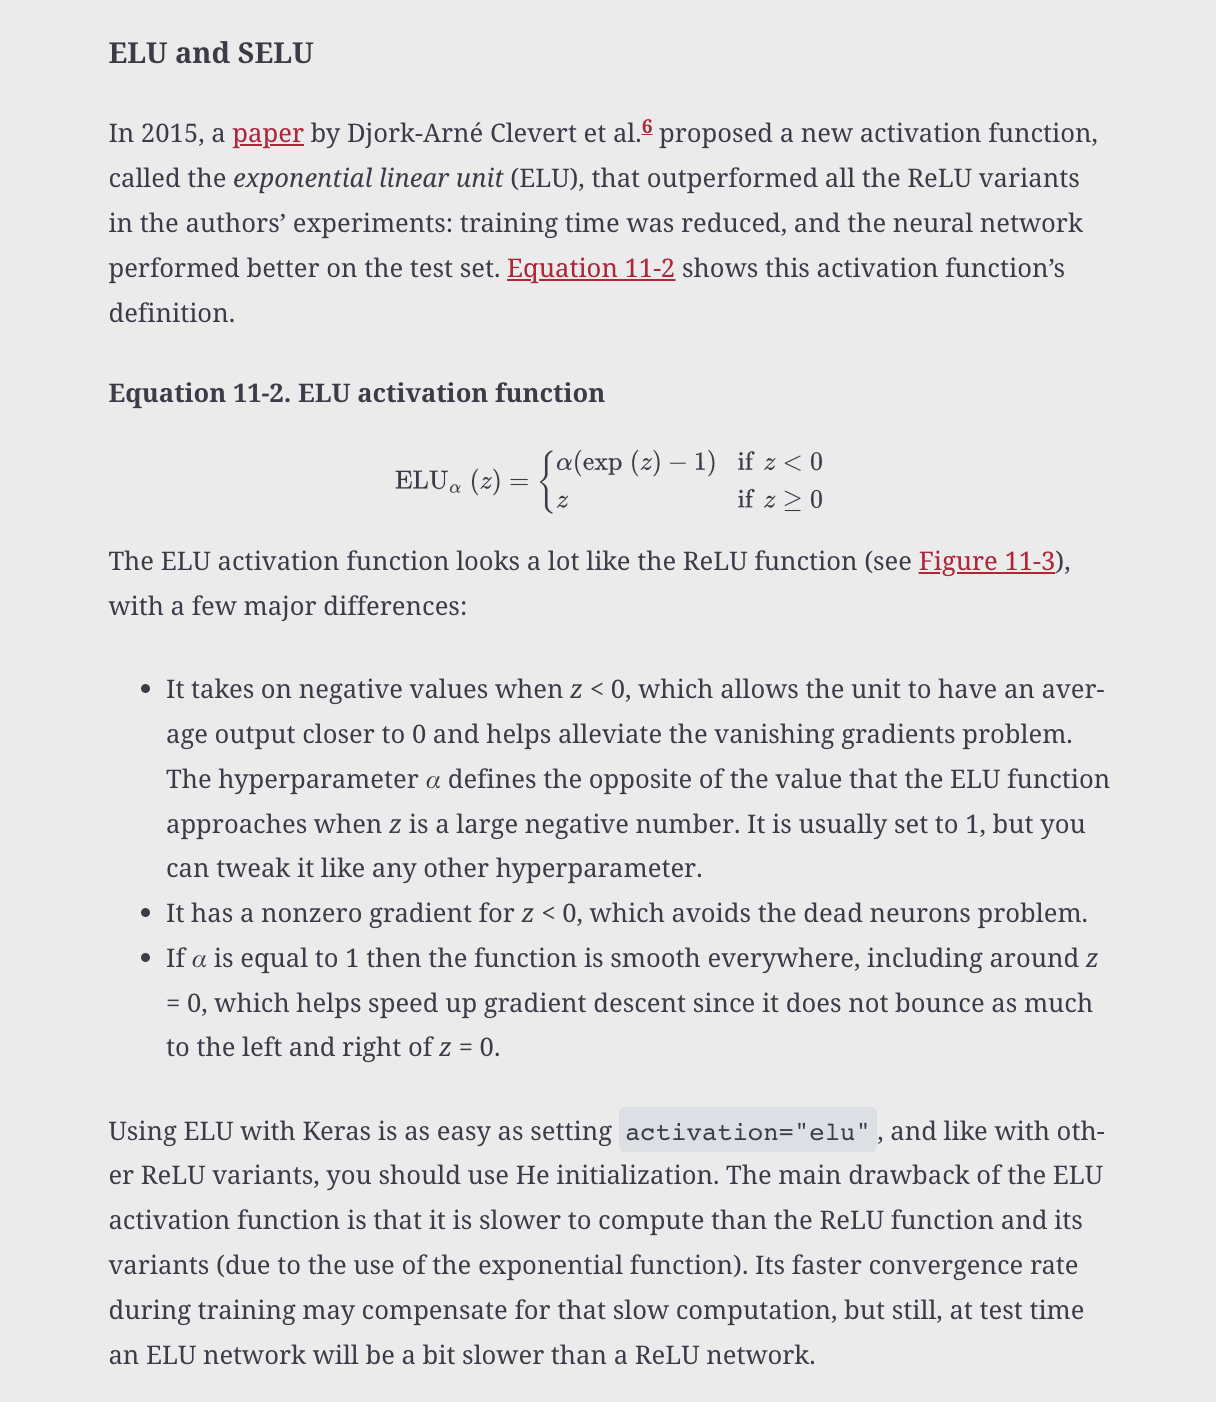

In [1]:
import sys

assert sys.version_info >= (3, 7)

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


#Batch Normalization

Sergey Ioffe and Christian Szegedy proposed a technique called batch normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. 